In [1]:
# necessary libraries
import os
import pandas as pd

# visualizations libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
%matplotlib inline

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# model evaluation libraries
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [2]:
base_dir= "D:\TbDB\TB_D"
os.listdir(base_dir)

['Normal',
 'Normal.metadata.xlsx',
 'README.md.txt',
 'Tuberculosis',
 'Tuberculosis.metadata.xlsx']

In [3]:
tuberculosis_data= r"D:\TbDB\TB_D\Tuberculosis"
print("tuberculosis images :\n" ,os.listdir(tuberculosis_data)[:5])

normal_data= r"D:\TbDB\TB_D\Normal"
print("\nnormal images :\n" ,os.listdir(normal_data)[:5])

tuberculosis images :
 ['Tuberculosis-1.png', 'Tuberculosis-10.png', 'Tuberculosis-100.png', 'Tuberculosis-101.png', 'Tuberculosis-102.png']

normal images :
 ['Normal-1.png', 'Normal-10.png', 'Normal-100.png', 'Normal-1000.png', 'Normal-1001.png']


In [4]:
print("no. of tuberculosis images :" ,len(os.listdir(tuberculosis_data)))
print("\nno. of normal images :" ,len(os.listdir(normal_data)))

no. of tuberculosis images : 700

no. of normal images : 3500


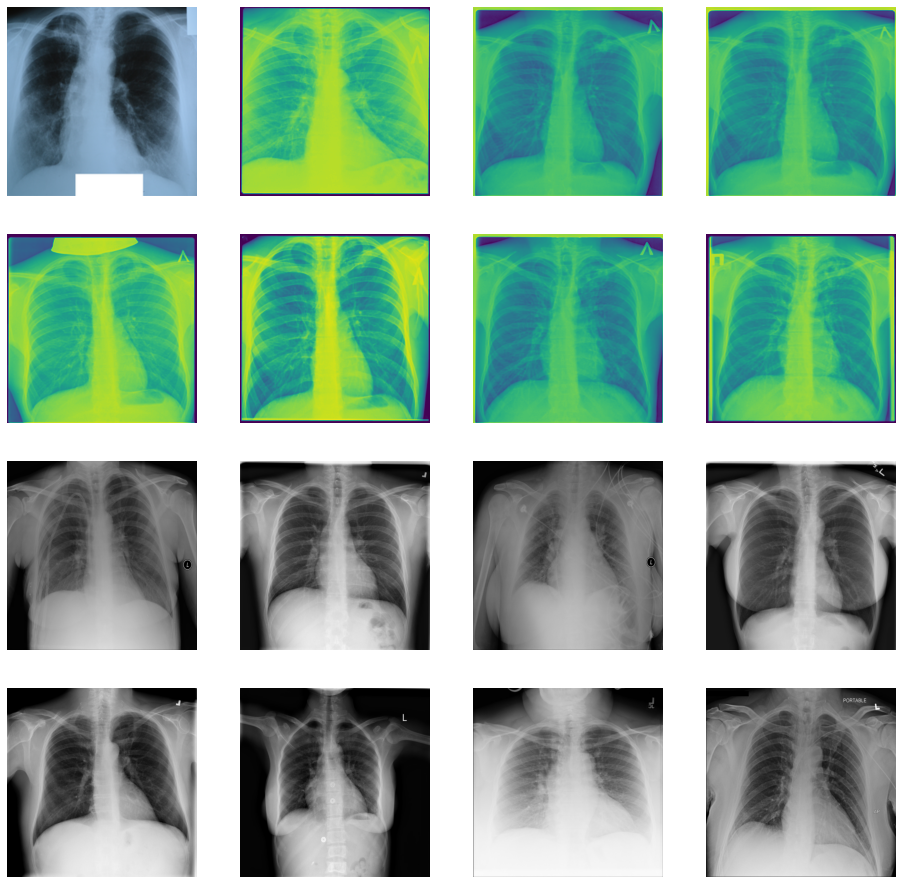

In [5]:
nrows= 4
ncols= 4
pic_index= 0

fig= plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index+=8

tuberculosis_img = [os.path.join(tuberculosis_data, image) for image in os.listdir(tuberculosis_data)[pic_index-8:pic_index]]
normal_img = [os.path.join(normal_data, image) for image in os.listdir(normal_data)[pic_index-8:pic_index]]

for i, image_path in enumerate(tuberculosis_img+normal_img):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 

    img = mpimg.imread(image_path)
    plt.imshow(img)

plt.show()

In [6]:
image= imread("D:\TbDB\TB_D\Tuberculosis\Tuberculosis-197.png")
image.shape

(512, 512, 3)

In [37]:
# generating training data
print("training data :")
train_datagen= ImageDataGenerator(rescale=1/255, zoom_range=0.3, rotation_range=50, width_shift_range= 0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', validation_split = 0.2)

train_data = train_datagen.flow_from_directory(base_dir, 
                                              target_size= (75, 75),
                                              class_mode= "binary",
                                              batch_size=20,
                                              subset= "training"
                                              )

# genarating validation data
print("\nvalidation data :")
val_datagen= ImageDataGenerator(rescale= 1/255, validation_split= 0.2)

val_data= train_datagen.flow_from_directory(base_dir, 
                                              target_size= (75, 75),
                                              class_mode= "binary",
                                              batch_size=20,
                                              shuffle= False,
                                              subset= "validation"
                                              )

training data :
Found 3360 images belonging to 2 classes.

validation data :
Found 840 images belonging to 2 classes.


In [8]:
train_data.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [36]:
from keras.applications import xception

base_model = xception.Xception(weights='imagenet',include_top=False,input_shape=(75,75, 3),pooling='avg')

83697664/83683744 [==============================] - 8s 0us/step


In [40]:
top_model = Sequential()

top_model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.5))

top_model.add(Dense(1, activation='sigmoid'))
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
history= model.fit(train_data,
                   steps_per_epoch= train_data.samples//train_data.batch_size,
                   validation_data= val_data,
                   validation_steps= val_data.samples//val_data.batch_size,
                   epochs= 10,
                   verbose=1 
                  )

Epoch 1/10
168/168 [==============================] - 142s 843ms/step - loss: 0.2149 - accuracy: 0.9185 - val_loss: 0.1910 - val_accuracy: 0.9238
Epoch 2/10
168/168 [==============================] - 132s 784ms/step - loss: 0.1129 - accuracy: 0.9625 - val_loss: 0.1620 - val_accuracy: 0.9357
Epoch 3/10
168/168 [==============================] - 163s 969ms/step - loss: 0.0889 - accuracy: 0.9699 - val_loss: 0.1931 - val_accuracy: 0.9202
Epoch 4/10
168/168 [==============================] - 158s 939ms/step - loss: 0.0742 - accuracy: 0.9750 - val_loss: 0.1053 - val_accuracy: 0.9560
Epoch 5/10
168/168 [==============================] - 164s 975ms/step - loss: 0.0708 - accuracy: 0.9780 - val_loss: 0.0710 - val_accuracy: 0.9774
Epoch 6/10
168/168 [==============================] - 171s 1s/step - loss: 0.0618 - accuracy: 0.9807 - val_loss: 0.0526 - val_accuracy: 0.9821
Epoch 7/10
168/168 [==============================] - 166s 985ms/step - loss: 0.0450 - accuracy: 0.9857 - val_loss: 0.0514 - va

In [ ]:
epochs= range(1, len(history.history["accuracy"])+1)

plt.plot(epochs, history.history["accuracy"], color="purple")
plt.plot(epochs, history.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, history.history["loss"], color="purple")
plt.plot(epochs, history.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [ ]:
import numpy as np
prediction= model.predict(val_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=2)
prediction= (prediction > 0.5)
prediction

In [ ]:
val_labels=val_data.classes
val_labels

In [ ]:
cm= confusion_matrix(val_data.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))

print(accuracy_score(val_data.classes, prediction))
print(classification_report(val_data.classes, prediction))